In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import wrangle_zillow
import model
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

In [2]:
df = wrangle_zillow.wrangle_zillow()
df = wrangle_zillow.handle_missing_zillow_values(df)
df = wrangle_zillow.remove_outliers(df, 3.0, ['bathroom', 'bedroom','square_feet','lot_size','tax_value'])

Using cached data
Shape before handling missing values: (77380, 61)
For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold
Shape after removing nulls: (50906, 53)
Number of observations removed: 4545


In [3]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [4]:
train, validate, test = model.add_features(train, validate, test)

Initially examine correlations between variables and target. No variables showed strong positive or weak correlation.

In [5]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.abs_logerror).sort_values(ascending=False)[2:].head(10)

age                     0.096562
taxdelinquencyflag      0.057685
has_old_heat            0.057519
taxdelinquencyyear      0.052777
is_la                   0.032553
regionidcounty          0.028588
tax_rate                0.026136
bed_bath_ratio          0.025916
land_dollar_per_sqft    0.014003
lot_size                0.013878
dtype: float64

### Which categorical features have statistically significant absolute log errors greater than the overall mean?

In [6]:
overall_mean = train.abs_logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

# print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].abs_logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].abs_logerror, train.abs_logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].abs_logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].abs_logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].abs_logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_abs_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size}).sort_values('difference_from_overall',ascending=False)
# Combine column name and option name
high_log_errors["column_option"] = high_log_errors.column.astype(str)+"-"+(high_log_errors.option.astype(str))

Text(0, 0.5, 'Feature')

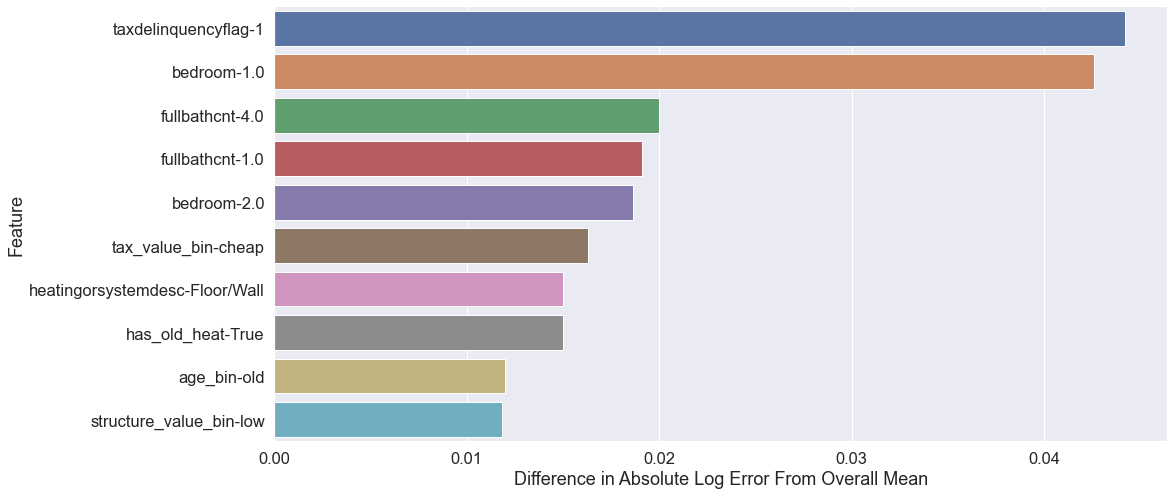

In [7]:
sns.barplot(data = high_log_errors.head(10), y = 'column_option', x = 'difference_from_overall')
plt.xlabel('Difference in Absolute Log Error From Overall Mean')
plt.ylabel('Feature')

### Looking for clusters in the top values:
- Old, Small, low tax value houses with outdated heating systems (age, square feet, tax value, heating system)
- Cheap structure and land valued homes (structure dollar per sqft, land dollar per sqft)
- High full bath counts and high bed to bath houses (fullbathcnt and bed_bath_ratio)
- Tax delinquent, smaller bathrooms counts (2 or less), cheaper tax values

In [8]:
# Scale required columns
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['age','square_feet','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft','fullbathcnt','bed_bath_ratio','bathroom'])

## Cluster on age, square feet, tax value, and old heat

Text(0.5, 0, '')

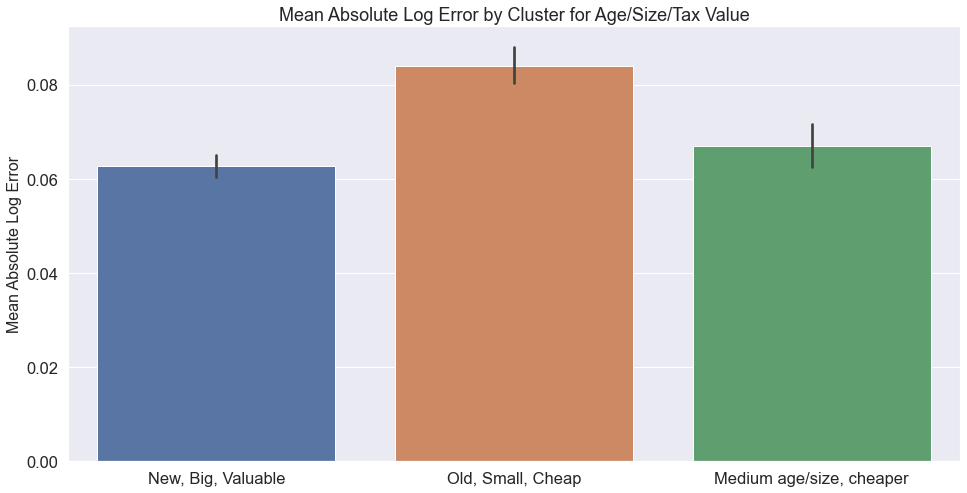

In [9]:
features_to_cluster = ['age_scaled','square_feet_scaled','tax_value_scaled','has_old_heat']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, plots = False)

rename_dict = {0:'Medium age/size, cheaper', 1:'Old, Small, Cheap', 2:'New, Big, Valuable'}
train_scaled = train_scaled.replace({'age_squ_tax_has_cluster':rename_dict})

sns.barplot(data = train_scaled, x = 'age_squ_tax_has_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Age/Size/Tax Value")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

<AxesSubplot:xlabel='square_feet', ylabel='abs_logerror'>

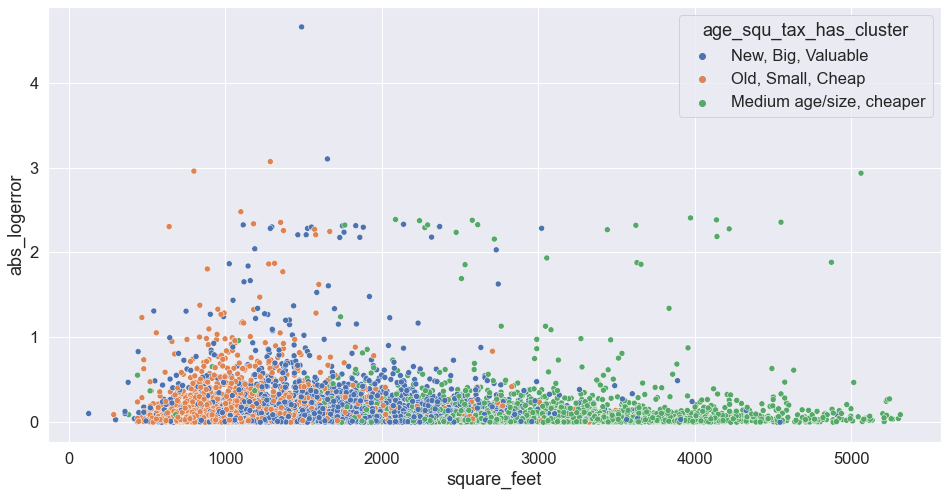

In [10]:
sns.scatterplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='age_squ_tax_has_cluster')

In [11]:
# train_scaled.groupby('age_squ_tax_has_cluster').mean()[['age','square_feet','tax_value','has_old_heat','abs_logerror']].sort_values('tax_value',ascending=False)

### Three cluster identified as:
- New, Big, High Tax Value, Newer heat
- Old, Small, Low Tax Value, Older heat ----> This cluster had higher than average absolute log error
- Medium age, Medium size, Lower tax value, Newer heat

### Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 

## Cluster on structure and land value and tax delinquency

Text(0.5, 0, '')

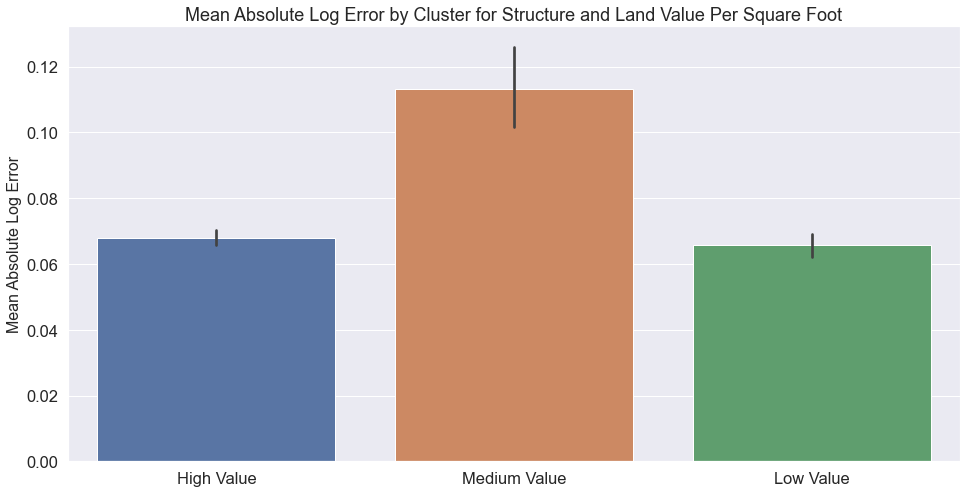

In [12]:
features_to_cluster = ['structure_dollar_per_sqft_scaled','land_dollar_per_sqft_scaled','taxdelinquencyflag']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, cluster_qty = 3, plots=False)

rename_dict = {0:'Low Value', 1:'Medium Value', 2:'High Value'}
train_scaled = train_scaled.replace({'str_lan_tax_cluster':rename_dict}).sort_values(by='structure_dollar_per_sqft')
sns.barplot(data = train_scaled, x = 'str_lan_tax_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Structure and Land Value Per Square Foot")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

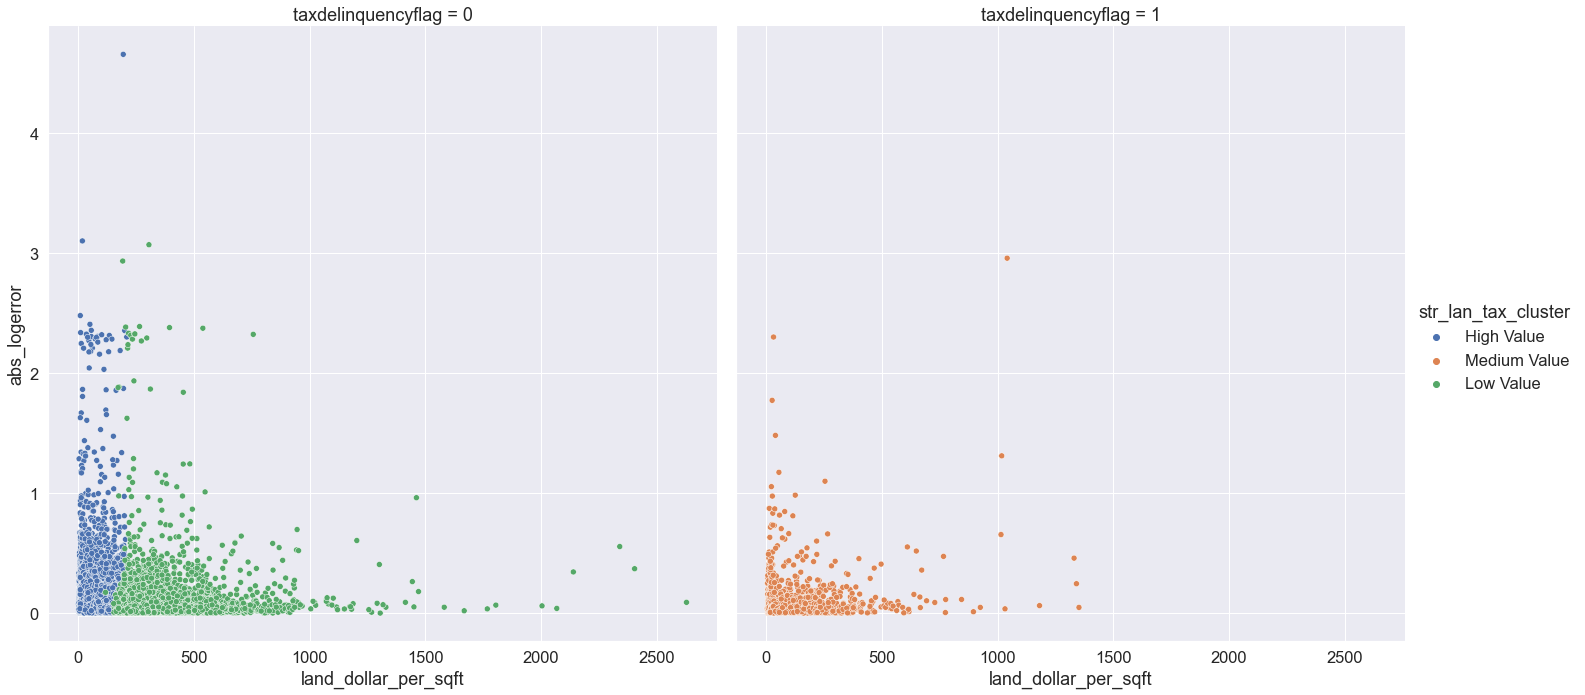

In [13]:
sns.relplot(data = train_scaled, x = 'land_dollar_per_sqft', y='abs_logerror', hue='str_lan_tax_cluster', height = 10, col = 'taxdelinquencyflag')

In [14]:
# train_scaled.groupby('str_lan_tax_cluster').mean()[['structure_dollar_per_sqft','land_dollar_per_sqft','abs_logerror','taxdelinquencyflag']].sort_values('land_dollar_per_sqft',ascending=False)

### Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.

## Cluster on full bath count and bed to bath ratio

Text(0.5, 0, '')

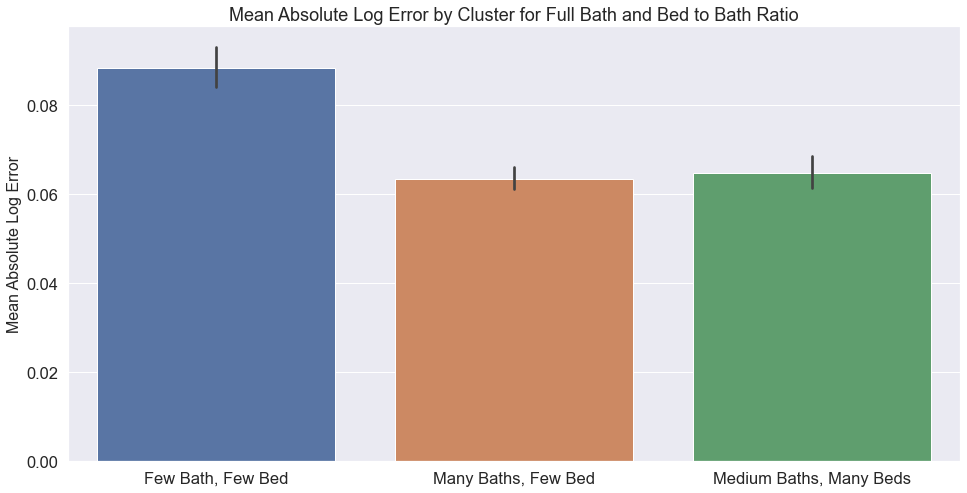

In [15]:
features_to_cluster = ['fullbathcnt_scaled','bed_bath_ratio_scaled']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, cluster_qty=3, plots=False)

rename_dict = {0:'Many Baths, Few Bed', 1:'Few Bath, Few Bed', 2:'Medium Baths, Many Beds'}
train_scaled = train_scaled.replace({'ful_bed_cluster':rename_dict}).sort_values(by='fullbathcnt')
sns.barplot(data = train_scaled, x = 'ful_bed_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

- Few full baths, low bed to bath ratios
- Medium full baths, Medium bed to bath ratios (number of full baths ~= number of beds)
- Few full baths, high bed to bath ratios - > this one shows statistically significant mean abs log error above overall average

In [16]:
# train_scaled.groupby('ful_bed_cluster').mean()[['fullbathcnt','bed_bath_ratio','abs_logerror','square_feet']].sort_values('abs_logerror',ascending=False)

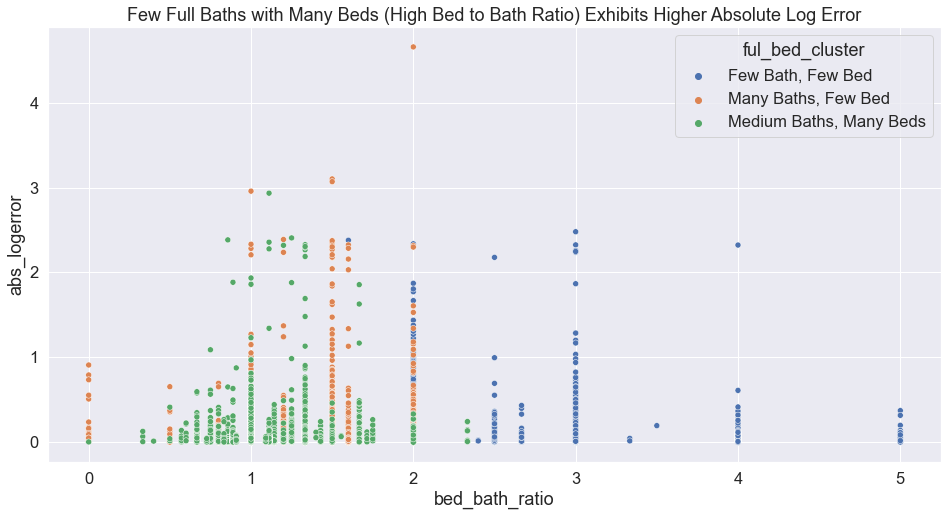

In [17]:
sns.scatterplot(data = train_scaled, x = 'bed_bath_ratio', y='abs_logerror', hue='ful_bed_cluster')
plt.title("Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error")
plt.show()

### Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error

## Cluster by tax delinquency, bathroom, tax values

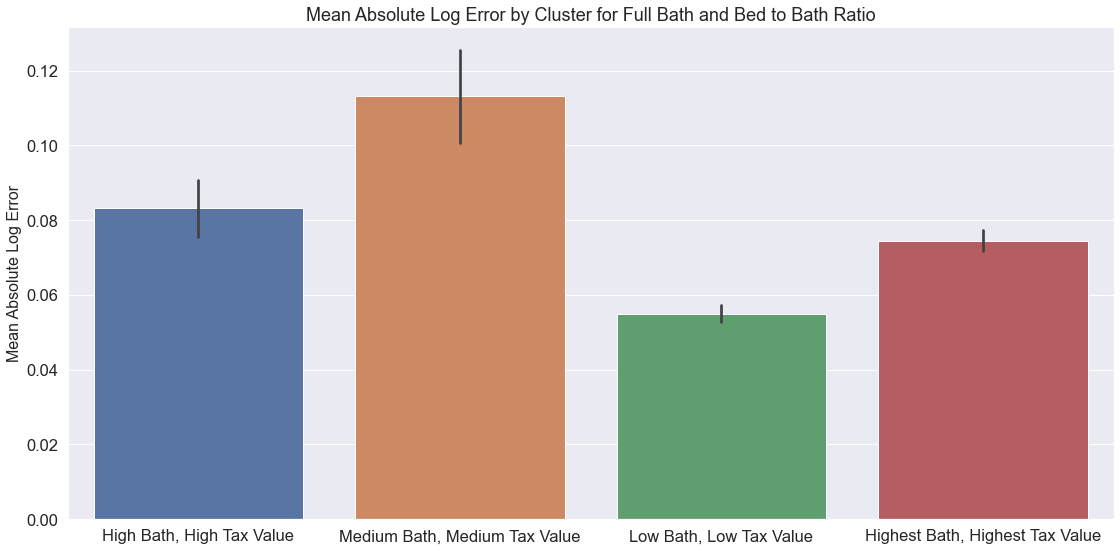

In [18]:
features_to_cluster = ['taxdelinquencyflag','bathroom_scaled','tax_value_scaled']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster,cluster_qty=4, plots=False)

rename_dict = {0:'Low Bath, Low Tax Value', 1:'High Bath, High Tax Value', 2:'Medium Bath, Medium Tax Value', 3:'Highest Bath, Highest Tax Value'}
train_scaled = train_scaled.replace({'tax_bat_tax_cluster':rename_dict}).sort_values(by='tax_value', ascending=False)
sns.barplot(data = train_scaled, x = 'tax_bat_tax_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.tight_layout()

In [19]:
# train_scaled.groupby('tax_bat_tax_cluster').mean()[['bathroom','tax_value','taxdelinquencyflag','abs_logerror']].sort_values('abs_logerror',ascending=False)

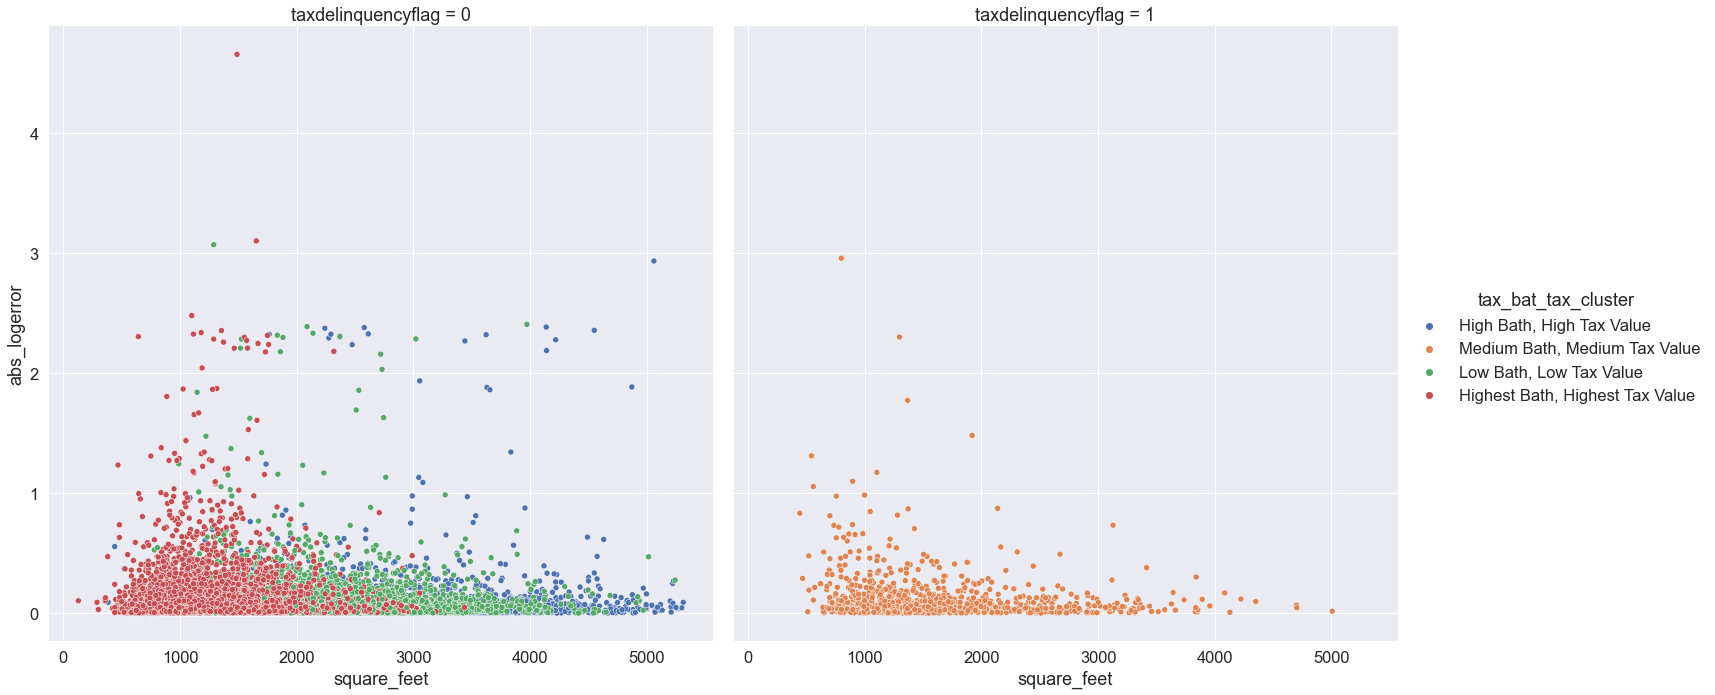

In [20]:
# plt.figure(figsize=(30,8))
sns.relplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='tax_bat_tax_cluster', height = 10, col='taxdelinquencyflag')

### Clusters are:
- Low Bath, Low Tax Value
- Medium Bath, Medium Tax Value and tax delinquent
- High Bath, High Tax Value
- Highest Bath, Highest Tax Value

### Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Exploration Takeaways:
- Size, age, tax value and tax delinquency are the greatest affect on absolute log error.
- Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 
- Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.
- Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error
- Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Regression Modeling
- Attempt to predict log error based on results from exploration
- Top features for model selection: 
    - age
    - size
    - tax value
    - tax delinquency status
    - bathroom count (correlated with size)

In [21]:
to_dummy=[]
# These are the features that need to be scaled
features_to_scale = ['age','square_feet','bathroom','tax_value']
# These are the features that will be fed into the model based on exploration
columns_to_use = ['age','square_feet','bathroom','tax_value','taxdelinquencyflag']

In [22]:
# Test each county with each regression algorithm
all_results = {}

# Perform scaling
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = model.data_scaling(train, validate, test, to_dummy, features_to_scale, columns_to_use)

In [23]:
X_train_scaled.columns

Index(['age', 'square_feet', 'bathroom', 'tax_value', 'taxdelinquencyflag',
       'age_scaled', 'square_feet_scaled', 'bathroom_scaled',
       'tax_value_scaled'],
      dtype='object')

In [24]:
columns_to_use = ['taxdelinquencyflag',
       'age_scaled', 'square_feet_scaled', 'bathroom_scaled',
       'tax_value_scaled']

In [25]:
rfe_features = model.model_feature_selection(X_train_scaled, y_train, columns_to_use)

In [26]:
# print(county, "Top Features:")
# print(rfe_features)
# Save results from fitting and predicting to a dictionary
model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features, show_test = False, print_results = True)

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17
RMSE for OLS using LinearRegression
Training/In-Sample:  0.1681553104703867 
Validation/Out-of-Sample:  0.1715777267447569
RMSE for OLS using LarsLasso
Training/In-Sample:  0.16827020271765275 
Validation/Out-of-Sample:  0.17189726668428837
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16796068007278206 
Validation/Out-of-Sample:  0.1713527717425706


,r2,mse,rmse
logerror,1.000000,0.000000,0.000000
log_error,1.000000,0.000000,0.000000
log_error_pred_mean,-0.000211,0.029549,0.171897
log_error_pred_median,-0.005814,0.029714,0.172378
log_error_pred_lm,0.003504,0.029439,0.171578
log_error_pred_lars,-0.000211,0.029549,0.171897
log_error_pred_lm2,0.006115,0.029362,0.171353


In [27]:
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, abs(y_train.log_error))

TweedieRegressor(alpha=0, power=1)